In [1]:
import glob
import re
import os
import sys
import kipoi
import numpy as np
import datetime
import warnings
import pandas as pd
import matplotlib.pyplot as plt
start = datetime.datetime.now()

old_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")
model = kipoi.get_model('DeepSEA/predict')
sys.stdout = old_stdout
batch_size=100
#sys.argv=[" ","5_158526788",5000,"gene_name",1,100,500000]
sys.argv=[" ","2_127864931",5000,"BIN1",1,100,500000]
sys.argv[2]=int(sys.argv[2])
sys.argv[4]=int(sys.argv[4])
sys.argv[5]=int(sys.argv[5])
sys.argv[6]=int(sys.argv[6])
#print(sys.argv[1])
with open("temp/"+sys.argv[1]+"/expression/"+sys.argv[1]+".tsv") as f:
    content = f.readlines()

content = [x.strip() for x in content]
content[0] = content[0].split()
content[1] = content[1].split()
answ=np.empty([sys.argv[2],445,919])
expr=np.empty([445])
i=0


FileNotFoundError: [Errno 2] No such file or directory: 'temp/2_127864931/expression/2_127864931.tsv'

In [2]:
for g in sorted(glob.glob("temp/"+sys.argv[1]+"/fa_output/out"+sys.argv[1]+"_*.fa.gz")):
    dl_kwargs = {'intervals_file': 'temp/'+sys.argv[1]+'/intervals/'+os.path.splitext(os.path.basename(g))[0], 'fasta_file': g, "num_chr_fasta": "False"}
    warnings.filterwarnings('ignore',category=FutureWarning)
    dl = model.default_dataloader(**dl_kwargs)
    #it = dl.batch_iter(batch_size=sys.argv[2])
    it = dl.batch_iter(batch_size=batch_size)
    for b in range(0,sys.argv[2],batch_size):
        batch = next(it)
        warnings.filterwarnings('default',category=FutureWarning)
        if (sys.argv[2]<=b+batch_size):
            answ[b:sys.argv[2],i,:]=model.predict_on_batch(batch['inputs'])
        else:
            answ[b:b+batch_size,i,:]=model.predict_on_batch(batch['inputs'])
    expr[i]=content[1][content[0].index(re.split('_|\.',g)[-3])]
    i+=1
np.save("answ", answ)
np.save("expr", expr)

In [3]:
#TRY
answ=np.load("answ.npy")
expr=np.load("expr.npy")

In [4]:
#TRY
import numpy as np
from scipy.stats import pearsonr
from scipy.special import betainc

def corrcoef(matrix):
    r = np.corrcoef(matrix)
    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2
    ts = rf * rf * (df / (1 - rf * rf))
    pf = betainc(0.5 * df, 0.5, df / (df + ts))
    p = np.zeros(shape=r.shape)
    p[np.triu_indices(p.shape[0], 1)] = pf
    p[np.tril_indices(p.shape[0], -1)] = pf
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])
    return r, p

"""
def corrcoef_loop(matrix):
    rows, cols = matrix.shape[0], matrix.shape[1]
    r = np.ones(shape=(rows, rows))
    p = np.ones(shape=(rows, rows))
    for i in range(rows):
        for j in range(i+1, rows):
            r_, p_ = pearsonr(matrix[i], matrix[j])
            r[i, j] = r[j, i] = r_
            p[i, j] = p[j, i] = p_
    return r, p"""


'\ndef corrcoef_loop(matrix):\n    rows, cols = matrix.shape[0], matrix.shape[1]\n    r = np.ones(shape=(rows, rows))\n    p = np.ones(shape=(rows, rows))\n    for i in range(rows):\n        for j in range(i+1, rows):\n            r_, p_ = pearsonr(matrix[i], matrix[j])\n            r[i, j] = r[j, i] = r_\n            p[i, j] = p[j, i] = p_\n    return r, p'

In [29]:
#TRY
#corrcoef(np.concatenate(a,[b])) ==> coef+pvalue
#np.corrcoef(a,b) ==> coef
correlations=np.empty([919,sys.argv[2]])
pvalues=np.empty([919,sys.argv[2]])
for i in range(sys.argv[2]):
    temp=corrcoef(np.concatenate([np.transpose(answ[i,:,:]),np.array([expr])]))
    correlations[:,i]=temp[0][-1][:-1]
    pvalues[:,i]=temp[1][-1][:-1]

 :9: RuntimeWarning: divide by zero encountered in true_divide
/home/antoine/mit_internship/miniconda3/envs/kipoi-DeepSEA__predict/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/home/antoine/mit_internship/miniconda3/envs/kipoi-DeepSEA__predict/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/antoine/mit_internship/miniconda3/envs/kipoi-DeepSEA__predict/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/antoine/mit_internship/miniconda3/envs/kipoi-DeepSEA__predict/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [3]:
start_cor = datetime.datetime.now()
correlations=np.empty([919,sys.argv[2]])
for i in range(sys.argv[2]):
    correlations[:,i]=np.corrcoef(np.transpose(answ[i,:,:]),expr)[-1][:-1]

/home/antoine/miniconda3/envs/kipoi-gpu-DeepSEA__predict/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/home/antoine/miniconda3/envs/kipoi-gpu-DeepSEA__predict/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/antoine/miniconda3/envs/kipoi-gpu-DeepSEA__predict/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/antoine/miniconda3/envs/kipoi-gpu-DeepSEA__predict/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


'df.to_csv("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv.gz")\n\n#np.savetxt("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv", correlations, delimiter=",")\n\ntest_time = open("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".time", \'w\')\ntest_time.write(str(start)+"\n"+str(start_cor)+"\n"+str(datetime.datetime.now()))\ntest_time.close()'

In [30]:
column_names = np.arange(sys.argv[4],sys.argv[6],sys.argv[5])-1-sys.argv[6]/2
with open('deepsea_postprocessing/predictor.names') as f:
    row_names = f.read().splitlines()

df = pd.DataFrame(correlations, columns=column_names, index=row_names)
"""df.to_csv("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv.gz")

#np.savetxt("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv", correlations, delimiter=",")

test_time = open("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".time", 'w')
test_time.write(str(start)+"\n"+str(start_cor)+"\n"+str(datetime.datetime.now()))
test_time.close()"""

'df.to_csv("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv.gz")\n\n#np.savetxt("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv", correlations, delimiter=",")\n\ntest_time = open("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".time", \'w\')\ntest_time.write(str(start)+"\n"+str(start_cor)+"\n"+str(datetime.datetime.now()))\ntest_time.close()'

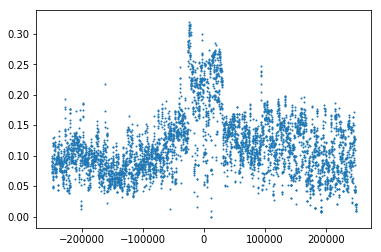

In [31]:
import matplotlib.pyplot as plt
df=df.fillna(0)
#print(list(df.abs().max().sort_values().iloc[-50:].index))
#print(df.abs().idxmax())
#df.abs().max().plot()
#plt.show()
plt.scatter(df.abs().max().index, df.abs().max(),s=1)
plt.show()

In [32]:
column_names = np.arange(sys.argv[4],sys.argv[6],sys.argv[5])-1-sys.argv[6]/2
with open('deepsea_postprocessing/predictor.names') as f:
    row_names = f.read().splitlines()

dfp = pd.DataFrame(pvalues, columns=column_names, index=row_names)
"""df.to_csv("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv.gz")

#np.savetxt("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv", correlations, delimiter=",")

test_time = open("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".time", 'w')
test_time.write(str(start)+"\n"+str(start_cor)+"\n"+str(datetime.datetime.now()))
test_time.close()"""

'df.to_csv("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv.gz")\n\n#np.savetxt("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv", correlations, delimiter=",")\n\ntest_time = open("correlations_para/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".time", \'w\')\ntest_time.write(str(start)+"\n"+str(start_cor)+"\n"+str(datetime.datetime.now()))\ntest_time.close()'

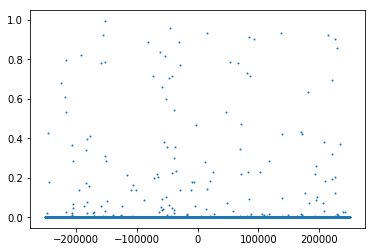

In [42]:
dfp=dfp.fillna(0)
#print(list(df.abs().max().sort_values().iloc[-50:].index))
#print(df.abs().idxmax())
#df.abs().max().plot()
#plt.show()
plt.scatter(dfp.abs().iloc[1].index, dfp.abs().iloc[1],s=1)
plt.show()

In [41]:
dfp.abs().iloc[1].index

Float64Index([-250000.0, -249900.0, -249800.0, -249700.0, -249600.0, -249500.0,
              -249400.0, -249300.0, -249200.0, -249100.0,
              ...
               249000.0,  249100.0,  249200.0,  249300.0,  249400.0,  249500.0,
               249600.0,  249700.0,  249800.0,  249900.0],
             dtype='float64', length=5000)

In [35]:
dfp

,-250000.0,-249900.0,-249800.0,-249700.0,-249600.0,-249500.0,-249400.0,-249300.0,-249200.0,-249100.0,...,249000.0,249100.0,249200.0,249300.0,249400.0,249500.0,249600.0,249700.0,249800.0,249900.0
8988T|DNase|None,6.789723e-55,4.971390e-87,3.266282e-213,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.367786e-165,...,0.000000e+00,4.125187e-82,5.274538e-15,1.959137e-119,0.000000e+00,5.043153e-310,7.590689e-221,1.554422e-250,2.208358e-295,1.088660e-235
AoSMC|DNase|None,1.202727e-133,1.137230e-192,3.686142e-299,2.605577e-246,0.000000e+00,0.000000e+00,1.728198e-221,0.000000e+00,0.000000e+00,8.754394e-253,...,1.494864e-285,0.000000e+00,3.231468e-111,0.000000e+00,4.732195e-199,3.880122e-200,0.000000e+00,9.701390e-146,7.183846e-37,2.145358e-59
Chorion|DNase|None,8.339946e-246,2.319058e-195,2.968174e-254,1.958582e-226,4.848089e-274,4.023298e-280,1.728753e-245,2.793002e-256,0.000000e+00,4.892336e-33,...,1.569047e-304,0.000000e+00,5.521800e-113,2.656895e-218,2.391609e-141,7.381438e-119,1.592111e-306,1.473622e-241,1.551380e-81,1.070216e-189
CLL|DNase|None,3.388117e-191,4.465613e-174,0.000000e+00,2.776645e-310,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.284638e-77,...,0.000000e+00,0.000000e+00,5.354808e-94,6.079693e-297,2.456183e-273,9.207613e-287,0.000000e+00,1.165997e-187,1.789845e-48,1.792754e-49
Fibrobl|DNase|None,2.595426e-162,4.297363e-98,4.306023e-211,1.565659e-254,2.404070e-202,4.777902e-102,9.088527e-184,7.835824e-233,9.007643e-258,1.875994e-136,...,2.163311e-221,4.924512e-24,2.214784e-02,1.523594e-72,3.055456e-249,1.390442e-19,4.818071e-21,2.432699e-89,1.176268e-105,3.632079e-310
FibroP|DNase|None,2.499449e-61,4.900650e-53,5.552409e-319,4.291781e-290,9.006675e-140,8.246343e-97,6.740388e-220,1.570034e-276,1.908023e-295,6.582560e-55,...,4.088752e-140,3.052316e-155,2.958540e-72,1.825026e-157,1.351959e-141,1.754864e-48,1.630698e-115,4.652159e-145,3.229021e-07,3.668997e-10
Gliobla|DNase|None,2.249811e-231,5.214303e-192,2.690795e-187,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.915340e-196,...,0.000000e+00,4.873105e-228,1.646352e-174,7.024129e-120,0.000000e+00,6.886280e-273,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GM12891|DNase|None,7.300974e-18,3.577754e-18,1.284334e-97,4.015334e-54,8.028484e-236,1.546121e-184,1.558760e-212,0.000000e+00,0.000000e+00,2.612051e-01,...,1.645458e-276,1.911021e-06,2.518750e-01,5.019827e-90,0.000000e+00,2.733472e-166,0.000000e+00,8.461081e-117,5.371020e-25,1.308663e-03
GM12892|DNase|None,1.168118e-57,3.553743e-93,3.057033e-06,6.464370e-106,3.858265e-45,7.479886e-182,3.894051e-59,4.764461e-116,8.750021e-15,9.316271e-26,...,1.604426e-69,3.341009e-160,5.035984e-148,3.453125e-18,1.851728e-22,8.335543e-10,1.112972e-02,3.202600e-07,1.732557e-25,2.027199e-96
GM18507|DNase|None,2.535654e-222,1.246063e-72,2.752747e-181,1.511865e-220,1.002867e-243,8.557727e-225,7.710141e-271,1.215631e-217,2.344944e-255,2.137048e-04,...,6.071591e-143,2.270916e-185,1.427078e-111,1.786709e-99,4.406660e-13,9.558441e-17,3.576377e-56,6.726638e-130,9.059975e-13,3.966279e-19


In [7]:
pos=df.abs().max().sort_values().iloc[-50:]
df[list(pos.index)].abs().mean(axis=1).sort_values()

NHEK|EZH2|None                        0.092858
Osteoblasts|H3K9me3|None              0.099977
ECC-1|ERalpha|BPA_100nM               0.100019
NH-A|EZH2|None                        0.101811
HMEC|EZH2|None                        0.103611
NHLF|EZH2|None                        0.105176
H1-hESC|DNase|None                    0.105266
ECC-1|ERalpha|Genistein_100nM         0.105945
HeLa-S3|ZKSCAN1|None                  0.106945
ECC-1|FOXA1|DMSO_0.02pct              0.107068
SK-N-SH_RA|p300|None                  0.107168
ECC-1|ERalpha|Estradiol_10nM          0.107496
K562|HDAC2|None                       0.107884
HeLa-S3|CTCF|None                     0.108019
Osteoblasts|H3K36me3|None             0.109319
H1-hESC|CTCF|None                     0.109410
WERI-Rb-1|DNase|None                  0.109821
H7-hESC|DNase|None                    0.109880
T-47D|GATA3|DMSO_0.02pct              0.109987
HepG2|ZNF274|None                     0.110117
H1-hESC|Pol2|None                     0.110367
NHDF-Ad|EZH2|

In [8]:
#get list of best positions
pos=df.abs().max().sort_values().iloc[-50:]
#get list of best mark at these positions
mark=df.abs().idxmax()[list(pos.index)]
import matplotlib.pyplot as plt

In [9]:
position_i=(df.columns.get_loc(list(pos.index)[-1]))
mark_i=(df.index.get_loc(list(mark)[-1]))

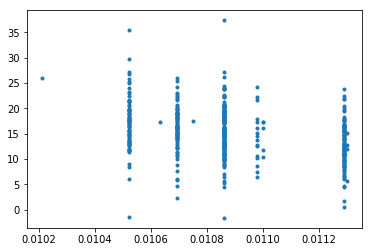

array([[ 1.       , -0.3198526],
       [-0.3198526,  1.       ]])

In [10]:
plt.plot(answ[position_i,:,mark_i] , expr,'.')
plt.show()
np.corrcoef(answ[position_i,:,mark_i] , expr)
#answ=np.empty([sys.argv[2],445,919])
#expr=np.empty([445])

In [11]:
__logBase10of2 = 3.010299956639811952137388947244930267681898814621085413104274611e-1
def RoundToSigFigs_fp( x, sigfigs ):
    """
    Rounds the value(s) in x to the number of significant figures in sigfigs.
    Return value has the same type as x.

    Restrictions:
    sigfigs must be an integer type and store a positive value.
    x must be a real value.
    """
    if not ( type(sigfigs) is int or type(sigfigs) is long or
             isinstance(sigfigs, np.integer) ):
        raise TypeError( "RoundToSigFigs_fp: sigfigs must be an integer." )

    if sigfigs <= 0:
        raise ValueError( "RoundToSigFigs_fp: sigfigs must be positive." )

    if not np.isreal( x ).all():
        raise TypeError( "RoundToSigFigs_fp: x must be real." )

    xsgn = np.sign(x)
    mantissa, binaryExponent = np.frexp( xsgn * x )

    decimalExponent = __logBase10of2 * binaryExponent
    omag = np.floor(decimalExponent)

    mantissa *= 10.0**(decimalExponent - omag)

    if mantissa < 1.0:
        mantissa *= 10.0
        omag -= 1.0

    return xsgn * np.around( mantissa, decimals=sigfigs - 1 ) * 10.0**omag

In [ ]:
#print(RoundToSigFigs_fp(answ,3))

In [14]:
np.savez_compressed('test_save_compressed',RoundToSigFigs_fp(answ,3))

MemoryError: 

In [12]:
#try to compare time with
np.round(answ,3)

array([[[0.034, 0.003, 0.021, ..., 0.042, 0.035, 0.01 ],
        [0.034, 0.003, 0.021, ..., 0.042, 0.035, 0.01 ],
        [0.034, 0.003, 0.021, ..., 0.042, 0.035, 0.01 ],
        ...,
        [0.036, 0.003, 0.022, ..., 0.042, 0.036, 0.009],
        [0.034, 0.003, 0.021, ..., 0.042, 0.035, 0.01 ],
        [0.034, 0.003, 0.021, ..., 0.042, 0.035, 0.01 ]],

       [[0.015, 0.015, 0.032, ..., 0.03 , 0.028, 0.007],
        [0.015, 0.015, 0.032, ..., 0.03 , 0.028, 0.007],
        [0.015, 0.015, 0.032, ..., 0.03 , 0.028, 0.007],
        ...,
        [0.016, 0.016, 0.034, ..., 0.031, 0.029, 0.007],
        [0.015, 0.015, 0.032, ..., 0.03 , 0.028, 0.007],
        [0.015, 0.015, 0.032, ..., 0.03 , 0.028, 0.007]],

       [[0.038, 0.106, 0.06 , ..., 0.028, 0.028, 0.007],
        [0.038, 0.106, 0.06 , ..., 0.028, 0.028, 0.007],
        [0.038, 0.106, 0.06 , ..., 0.028, 0.028, 0.007],
        ...,
        [0.039, 0.105, 0.063, ..., 0.029, 0.029, 0.007],
        [0.038, 0.106, 0.06 , ..., 0.028, 0.0